In [6]:
import sys

!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install graphviz

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [12]:
def f(x):
    return 3*x**2 - 4*x + 5

In [13]:
f(3.0)

20.0

In [14]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [15]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

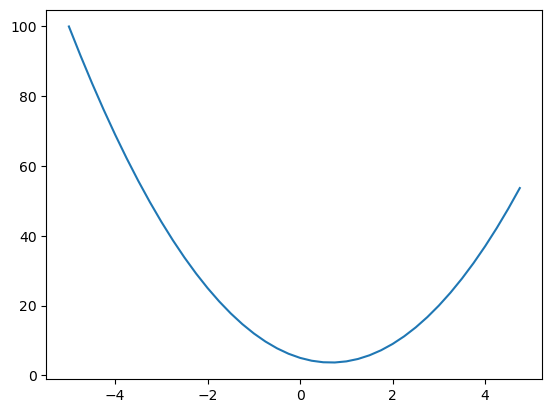

In [16]:
plt.plot(xs, ys)

In [17]:
h = 0.00000001
x = 3.0
(f(x+h)-f(x))/h
# derivative of 3x^2 - 4x + 5 = 6x-4 = 18-4 = 14
# this derivative is 0 at 2/3

14.00000009255109

In [18]:
# multiple scalars
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)
# lets look at the derivatives of d with respect to a/b/c

4.0


In [19]:
h = 0.001

# point (a,b,c) at which we're going to be evaluating d with respect to abc
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [21]:
# wraps a value
class Value:
    # `()` is an empty tuple
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # derivative of L with respect to this value
        # 0 means "no effect" (gradient 0)
        self.grad = 0.0
        # default to nothing, on a leaf node there is nothing to do
        self._backward = lambda: None
        self._prev = set(_children) # set is cheaper than tuple
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    # we could implement `__exp__` instead... but want to show here
    # that we can build functiond at arbitrary places in the complexity
    # stack
    # !! AS LONG AS WE KNOW THE LOCAL DERIVATIVE !!
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                # each node only adds itself to the list
                # after all of its children have been processed
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [164]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label='d' # (a.__mul__(b)).__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L # "loss function"
# L is the value of the FORWARD PASS... -8

Value(data=-8.0)

In [39]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [40]:
d._op

'+'

In [41]:
d.label

'd'

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [113]:
# if you increase L by 1, L increases by 1
L.grad = 1.0

# L = d * f
# what is dL/dd
# it's f

# derivative is (f(x+h)-f(x))/h
# the function here is f(x): f * x => where 1st f is function symbol, 2nd f is var
# increasing d by h... ((d+h)*f - d*f)/h
# (d*f + h*f - d*f)/h
# = (h*f)/h = f

# so also dL/df = d

f.grad = 4.0
d.grad = -2.0

# dL / dc
# (f(x+h)-f(x))/h
# the function here is f(x) = x + e
# increasing c by h ... ((c+e+h)-(c+e))/h
# (c-c+e-e+h)/h = h/h = 1
# => this is how c impacts d
# so c*d.grad = how c impacts L (n.grad is dn)
# dL/dc = dL/dd * dd/dc
# 1.0 * -2.0 = -2.0

# this is the chain rule in calculus...
# https://en.wikipedia.org/wiki/Chain_rule
# the calculus notation is confusing, this is better:
# dz/dx = dz/dy * dy/dx (Leibniz notation)
# "if a car travels 2x as fast as a bike, and a bike travels 4x as
#  fast as a walking person, the car is 8x as fast as the person"

# same for e

e.grad = 1.0 * -2.0
c.grad = 1.0 * -2.0

# b and a
# de/db = a, de/da = b
# so that's how a/b impact e
# so to get how it impacts L, multiply by de
# da = b*de = -3*-2 = 6
# db = a*de = 2*-2 = -4

a.grad = -3.0 * -2.0 # 6
b.grad = 2.0 * -2.0 # -4

In [116]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f
L # "loss function"

Value(data=-0.447488000000002)

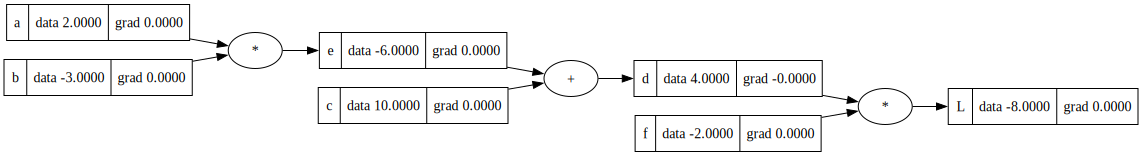

In [167]:
draw_dot(L) 

## Manual Backpropagation

In [51]:
# now we want to "backpropagate"
# abcdef will eventually represent the weights of the neural net
# and we want to know how they impact the loss function L
#
# we are interested in the derivative of the output with respect to some of its leaf nodes
# and those lef nodes will be the weights
# ...and other leaf nodes will be the data itself
# usually we will not want/use the derivative of the loss function with respect to the data
# because the data is fixed
# but the weights will be iterated on

In [84]:
def lol():

    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d' # (a.__mul__(b)).__add__(c)
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d' # (a.__mul__(b)).__add__(c)
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

-4.000000000008441


# Neuron (Neural Networks)

![neural net](./_resources/neural_net2.jpg)
example: 3-layer (input + 2 hidden layers of 4 neurons each). note no connections within a layer.

neurons have
- weights (how strong each input is)
- biases (how trigger happy the neuron is)
- activation function

inputs.reduce((acc, cur) => acc + cur.value * cur.weight, 0) + bias

then it's run through an activation function. these make the network non-linear. examples:

ReLU (Rectified Linear Unit) - introduces non-linearity, avoids vanishing gradients
- `const relu = (x) => Math.max(0, x)`
- non-linear because otherwise no matter how many layers you stack it's still just a linear function.
- avoiding vanishing gradients because otherwise many derivatives approach 0, making the further back layers useless

Sigmoid
- `const sigmoid = (x) => 1 / (1 + Math.exp(-x));`
- clamps between 0-1, useful for probabilities

Tanh (Hyperbolic Tangent)
- `const tanh = (x) => Math.tanh(x);`
- cosh(x)/sinh(x) = (e^x - e^-x)/(e^x + e^-x) = (e^2x - 1)/(e^2x + 1)
- similar to sigmoid but between -1 to 1

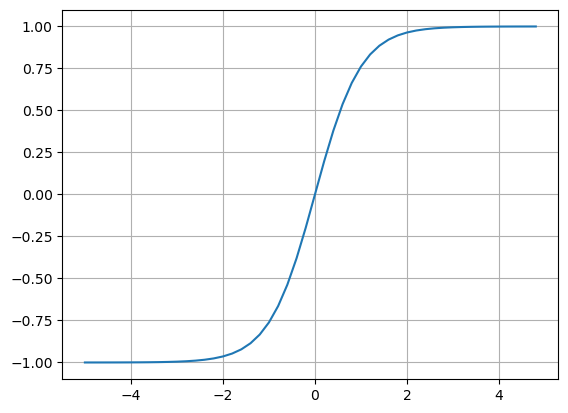

In [120]:
# tanh
# very large neg inputs get capped at -1, very large positive inputs get capped at 1
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [7]:
# lets write out a neuron
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights / synaptic strengths for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' # no activation function for now

o = n.tanh(); o.label = 'o' # output
(n,o)

# example outcomes
# bias 6.0: n = 0.0, o = 0.0 
# bias 6.1: n = 0.1, o = 0.0997
# bias 6.7: n = 0.7, o = 0.6044
# bias 8.0: n = 2.0, o = 0.9640 => squashed!
# bias 10.0: n = 4.0, o = 0.9993
# bias 100.0: n = 94.0, o = 1.0000 (rounded)

(Value(data=0.8813735870195432), Value(data=0.7071067811865476))

In [8]:
# we mostly care about the derivatives of the neurons on the
# weights, because the weights are what we will be changing

o.grad = 1.0

# o = tanh(n)
# what is do/dn? => wiki tells us 1-(tanh(x)^2)
# we know tanh(n) = 0 => do/dn = 1 - o**2 = 0.5
n.grad = 0.5

# + is just a distributor of a gradient
x1w1x2w2.grad = 1 * n.grad # 0.5
b.grad = 1 * n.grad # 0.5 

# same with x1w1 and x2w2 because they're also added
x1w1.grad = 1 * x1w1x2w2.grad # 0.5
x2w2.grad = 1 * x1w1x2w2.grad # 0.5

# now multiplication
x1.grad = w1.data * x1w1.grad # -1.5
w1.grad = x1.data * x1w1.grad # 1
x2.grad = w2.data * x2w2.grad # 0.5
w2.grad = x2.data * x2w2.grad # 0

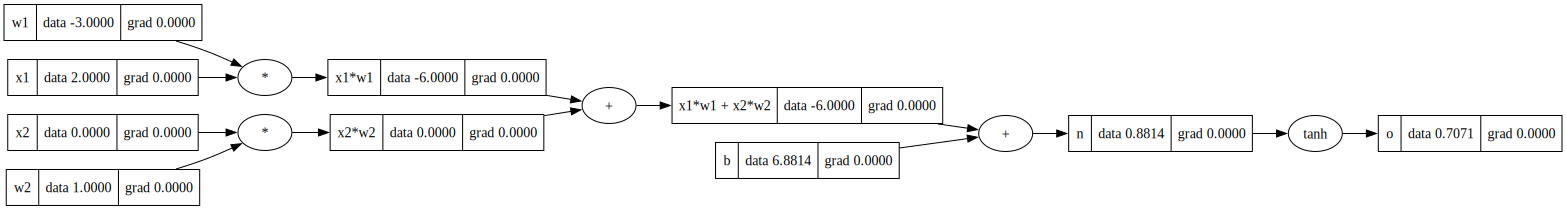

In [169]:
draw_dot(o)

## Now let's stop doing backpropagation manually

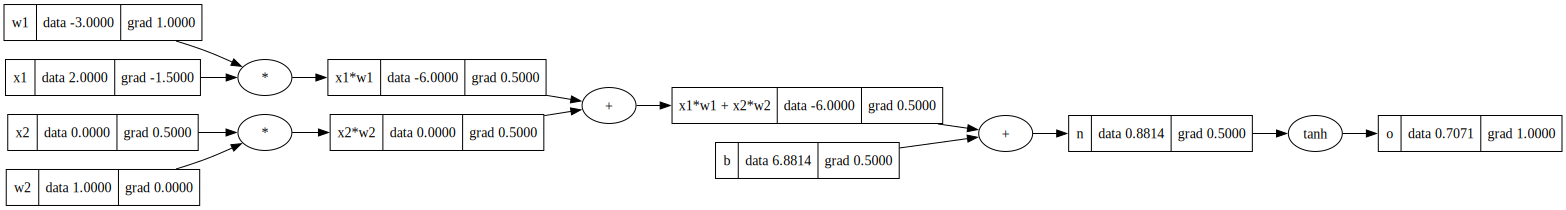

In [177]:
o.grad = 1.0 # base case, otherwise we multiply by 0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

## That's still kind of manual...

we don't want to call `._backward()` for any node before we've done everything after it. we need to get its full dependencies first before we can continue backpropagation

this ordering of graphs can be achieved using topological sort

topological sort: laying out nodes in a graph so that all the edges go from left to right

![foo](./_resources/topo.jpeg)

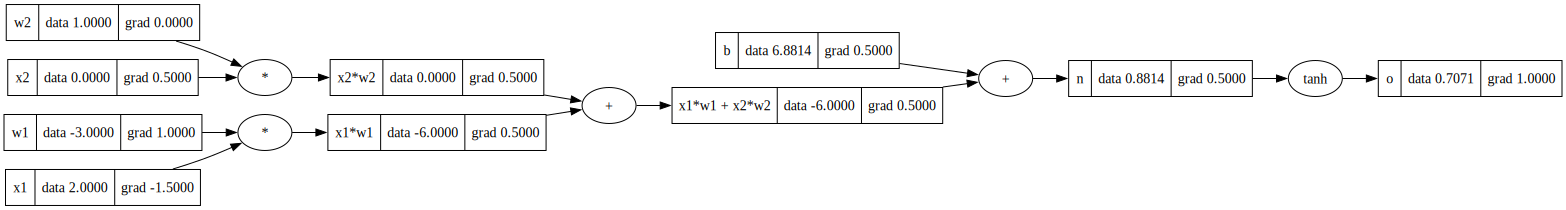

In [13]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        # each node only adds itself to the list
        # after all of its children have been processed
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

## And now we use the `.backward()` that we built on the Value class...

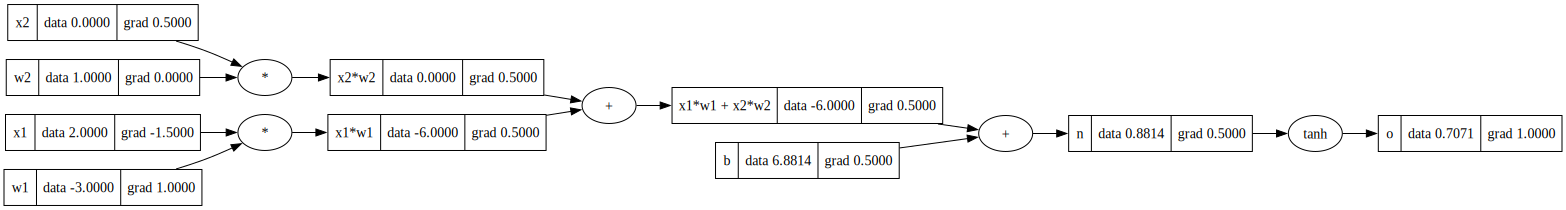

In [18]:
# same data as before
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

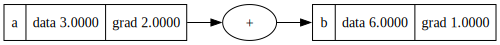

In [22]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

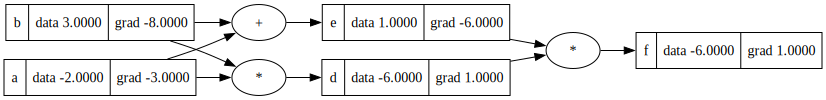

In [23]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)